# Example 3 - Optimisation routine

In Examples 2a and 2b we computed the Curie depth for a single point using a fixed window. Here, we use `CurieOptimise` object to compute the Curie depth over an entire magnetic anomaly.

`CurieOptimise` inherits all methods from `CurieGrid` in addition to:

- iteratively evaluate the Curie depth across the magnetic anomaly
- add priors to limit spurious Curie depth determinations
- optimise Curie depth parameters using constraints from an objective function

### Contents

- [The inverse problem](#The-inverse-problem)
- [Sensitivity analysis](#Sensitivity analysis)
- [Compare Bouligand to Tanaka](#Compare-Bouligand-to-Tanaka)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pycurious

In [2]:
# load x,y,anomaly
mag_data = np.loadtxt("../data/test_mag_data.txt")

nx, ny = 305, 305

x = mag_data[:,0]
y = mag_data[:,1]
d = mag_data[:,2].reshape(ny,nx)

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# initialise CurieOptimise object
grid = pycurious.CurieOptimise(d, xmin, xmax, ymin, ymax)

In [3]:
# get centroids

window_size = 200e3
xc_list, yc_list = grid.create_centroid_list(window_size, spacingX=10e3, spacingY=10e3)

print("number of centroids = {}".format(len(xc_list)))

## The inverse problem

It is notoriously difficult to estimate uncertainties from Curie depth determinations. Intuitively, the fewer points in the power spectrum should result in higher uncertainty, but it is difficult to quantify these uncertainties in practise. For [Bouligand *et al.*, 2009](http://doi.wiley.com/10.1029/2009JB006494) it is difficult to determine the values of $\beta$ and $\Delta z$ since both control the slope of the power spectrum at low wavenumbers. Similarly, for [Tanaka *et al.*, 1999](http://linkinghub.elsevier.com/retrieve/pii/S0040195199000724) the lower and upper ranges of the power spectrum used to compute $z_b$ and $z_t$ is highly subjective and can result in significantly different Curie depths.

Here, we aim to assess the uncertainty of Curie depth determinations using a sensitivity analysis. The approach we outline here is not necessarily the most statistically robust methodology, but it is intended as a practical means to compute Curie depth whilst considering its uncertainty.

First we find the best model with no priors to evaluate the heterogeneity in the signal we extract from the magnetic anomaly. We use the commonly used $\ell_2$-norm objective function to calculate misfit. The objective function can be accessed (and modified) under `grid.objective_function`

In [ ]:
# no priors
grid.reset_priors()

beta, zt, dz, C = grid.optimise_routine(window_size, xc_list, yc_list)

# plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,10))

sc1 = ax1.scatter(xc_list, yc_list, c=beta)
sc2 = ax2.scatter(xc_list, yc_list, c=zt)
sc3 = ax3.scatter(xc_list, yc_list, c=dz)
sc4 = ax4.scatter(xc_list, yc_list, c=C)

fig.colorbar(sc1, ax=ax1, label=r"$\beta$")
fig.colorbar(sc2, ax=ax2, label=r"$z_t$")
fig.colorbar(sc3, ax=ax3, label=r"$\Delta z$")
fig.colorbar(sc4, ax=ax4, label=r"$C$")

## Sensitivity analysis

The sensitivity analysis requires defining a prior distribution to sample from. The default is a Gaussian normal distribution,

$$
P(\mathbf{m}) = \frac{1}{\sqrt{2\pi} \sigma_p} \exp \left( \frac{-\mathbf{m}^2}{2 \sigma_p^2} \right)
$$

but other distributions can be defined from the `scipy.stats` module. We repeat the inversion multiple times, sampling different values from $P(\mathbf{m})$ to evaluate the uncertainty in each variable. Note: $\mathbf{m}$ is the variables $\beta, z_t, \Delta z, C$ for the Bouligand approach or $z_t, z_b $ for the Tanaka approach.

Prior distributions are added by

```python
from scipy import stats
beta_p = stats.norm(3.0, 1.0)
grid.add_prior(beta=beta_p)
```

and can be accessed from a dictionary:

```python
prior = grid.prior_pdf['beta'] # stats.norm object
prior = grid.prior['beta'] # stats.norm object arguments (3.0, 1.0)
```

In [ ]:
from scipy import stats

beta_p = stats.norm(3.0, 1.0)
zt_p = stats.norm(0.0, 1.0)
dz_p = stats.norm(12.0, 8.0)
C_p = stats.norm(-17.0, 5.0)

grid.add_prior(beta=beta_p, zt=zt_p, dz=dz_p, C=C_p)

In [ ]:
# number of simulations to run for each centroid
nsim = 10

beta, zt, dz, C = grid.sensitivity_routine(nsim, window_size, xc_list, yc_list)

In [ ]:
fig = plt.figure(figsize=(16,4))


for i, (label, var) in enumerate([('beta', beta), ('zt', zt), ('dz', dz), ('C', C)]):
    
    # prior distribution
    prior = grid.prior_pdf[label]
    p, sigma_p = prior.mean(), prior.std()
    
    # posterior distribution
    P, sigma_P = var[:,0].mean(), var[:,1].mean()
    post = stats.norm(P, sigma_P)
    
    x_samples = np.linspace(p-2*sigma_p, p+2*sigma_p, 100)
    
    # plot pdf
    ax = fig.add_subplot(1,4,i+1, xlabel=label)
    ax.plot(x_samples, prior.pdf(x_samples), label="prior")
    ax.plot(x_samples, post.pdf(x_samples), label="posterior")
    ax.legend()

The precision of the values are properly resolved 

### Parameter Exploration of Spectral Analysis method (Tanaka)

Due to the deterministic approach that [Tanaka *et al.*, 1999](http://linkinghub.elsevier.com/retrieve/pii/S0040195199000724) uses for estimating $Z_b$, the uncertainties returned by `CurieGrid.tanaka1999` are the simple results of error propagation from the initial spectra uncertainties. It should also be noted that the spectra uncertainties represent the variance within the sampled sector of the 2D FFT, and may comprise both noise and anisotropic signal.

We present here several tests of the `CurieGrid.tanaka1999` function in order to explore how the input parameters affect the resulting Curie point depth estimates. In particular, we consider the following:
1. Effect of where in $k$-space is specific window used, separately for both the power and $k$-weighted power spectra (i.e., which $k$ do we consider?).
2. Effect of $k$-space window size (i.e., how much of the $k$-domain do we consider?). It is important to note that increasing the $k$-bandwidth also stabilises the estimation by increasing the statistics of the spectrum portion.
3. Effect of magnetic data window size (i.e., domain of magnetic data before computing FFT).


In [4]:
#Default set up
grid = pycurious.CurieOptimise(d, xmin, xmax, ymin, ymax)
xpt = xmin + (xmax-xmin)/2
ypt = ymin + (ymax-ymin)/2

In [69]:
# 1) Where in k-space do we locate window?
ws=304e3
subgrid = grid.subgrid(xpt, ypt, ws)
S, k, sigma2 = grid.radial_spectrum_log(subgrid, taper=None)
# Number of bins to divide k-range into
nb=10
hmap=np.zeros((nb*nb,3))
# k-range divided between 0 (i.e., DC), and 0.3 (i.e., spatial wavelengths of ~20 km)
kmin_range = np.linspace(0., 0.3, nb)
kmax_range = kmin_range + (0.3/nb)

for j in range(0,nb,1):
    for l in range(0,nb,1):
        kmin0 = kmin_range[j]
        kmin1 = kmax_range[j]
        kmax0 = kmin_range[l]
        kmax1 = kmax_range[l]
        [(Ztr,btr,dZtr), (Zor, bor, dZor)]=pycurious.tanaka1999(S, k, sigma2, (kmin0, kmin1), (kmax0, kmax1))
        [Zb,eZb]=pycurious.ComputeTanaka(Ztr, dZtr, Zor, dZor)
        hmap[j*nb+l,0]=(kmin0+kmin1)/2
        hmap[j*nb+l,1]=(kmax0+kmax1)/2
        hmap[j*nb+l,2]=Zb

Text(0.5,1,u'Heatmap of CPD')

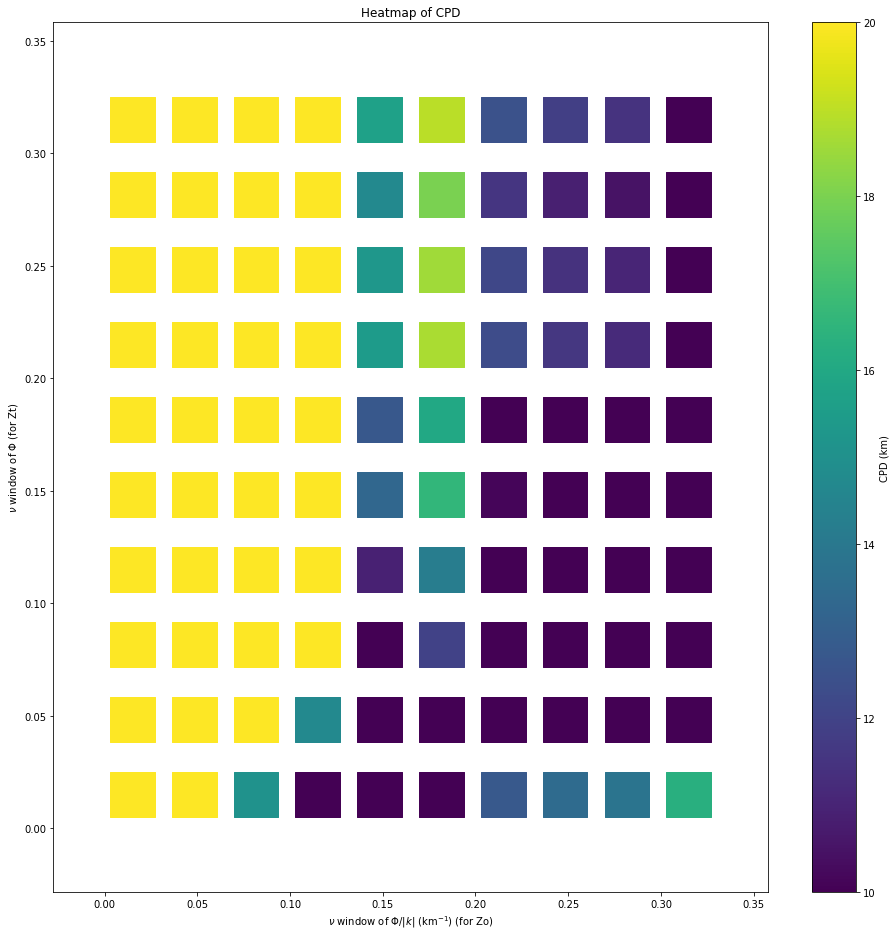

In [70]:
fig2 = plt.figure(figsize=(16,16))
ax2 = fig2.add_subplot(111, xlabel=r'$\nu$ window of $\Phi/|k|$ (km$^{-1}$) (for Zo)', ylabel=r'$\nu$ window of $\Phi$ (for Zt)')
# SCATTER PLOT
im2 = ax2.scatter(hmap[:,1],hmap[:,0],2000,np.clip(hmap[:,2],10,20),marker='s')
fig2.colorbar(im2, label='CPD (km)')
plt.title('Heatmap of CPD')

Results of this test suggest that the precise $k$ location of $Z_t$ is significantly less influential than the $k$ location of $Z_o$. Furthermore, for this test case with a known $Z_b$ of 16 km, a spatial frequency $\nu$ window of $0.125-0.2$ (i.e., $k\in\{0.8-1.25\}$ gives estimates consistent with the true $Z_b$. For simplicity, based upon this test we see minimal reason to not use the same $\nu/k$ window for each spectrum.

Text(0,0.5,u'CPD depth (km)')

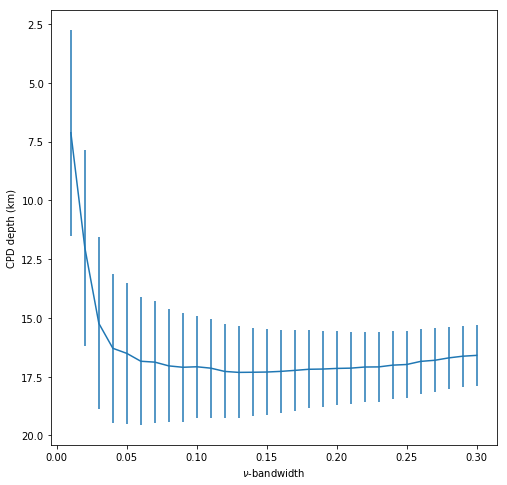

In [101]:
# 2) How big a bandwidth in k-space do we want?
#ws=304e3
#subgrid = grid.subgrid(xpt, ypt, ws)
S, k, sigma2 = grid.radial_spectrum_log(subgrid, taper=None)

# We are testing this by taking one central spatial frequency (k=1), and estimating Zb with increasing k-bandwidths.
# Recall k=2*pi*nu
nu=1/(2*np.pi)

nbins=30
output=np.zeros((nbins,3))
nr = np.linspace(0., 0.3, nbins+1)
output[:,0]=nr[1:]

for j in range(0,nbins,1):
    
    kmin=nu-output[j,0]/2
    kmax=nu+output[j,0]/2
    
    [(Ztr,btr,dZtr), (Zor, bor, dZor)]=pycurious.tanaka1999(S, k, sigma2, (kmin, kmax), (kmin, kmax))
    [Zb,eZb]=pycurious.ComputeTanaka(Ztr, dZtr, Zor, dZor)
    output[j,1]=Zb
    output[j,2]=eZb
    
fig2 = plt.figure(figsize=(8,8))
ax2=plt.errorbar(output[:,0],output[:,1],yerr=output[:,2])
plt.gca().invert_yaxis()
plt.xlabel('$\\nu$-bandwidth')
plt.ylabel('CPD depth (km)')

The CPD estimates resulting from this test become consistent for $\nu$-bandwidths greater than approximately 0.1. Statistics improve with larger bandwidths, however, it is worth remaining aware of the typically non-linear trend of the spectrum, as it may not be appropriate for a linear fit over a large domain of $\nu$.

Text(0,0.5,u'CPD misfit (km)')

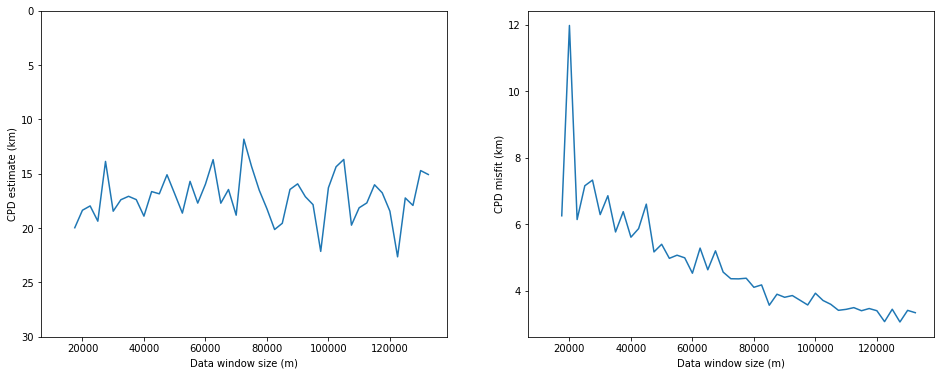

In [134]:
# 3) How large a window width of magnetic data is required?
grid = pycurious.CurieOptimise(d, xmin, xmax, ymin, ymax)
xpt = xmin + (xmax-xmin)/2
ypt = ymin + (ymax-ymin)/2

nwin=50
baseW=10000
inc=2500

output=np.zeros((nwin,3))

# Define 'ws' as variable window size index
for i in range(0,nwin,1):
    ws=baseW+i*inc
    subgrid = grid.subgrid(xpt, ypt, ws)
    S, k, sigma2 = grid.radial_spectrum_log(subgrid, taper=None)
    [(Ztr,btr,dZtr), (Zor, bor, dZor)]=pycurious.tanaka1999(S, k, sigma2, (0.11, 0.21), (0.11, 0.21))
    [Zb,eZb]=pycurious.ComputeTanaka(Ztr, dZtr, Zor, dZor)
    output[i,0]=ws
    output[i,1]=Zb
    output[i,2]=eZb
    #print('Zb estimate for '+str(ws)+' m: '+np.array2string(Zb)+', +/- '+np.array2string(eZb)+' km')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6),)
ax1.plot(output[:,0],output[:,1])
ax1.set_ylim(0,30)
ax1.invert_yaxis()
ax1.set_xlabel('Data window size (m)')
ax1.set_ylabel('CPD estimate (km)')

ax2.plot(output[:,0],output[:,2])
ax2.set_xlabel('Data window size (m)')
ax2.set_ylabel('CPD misfit (km)')
#plt.gca().invert_yaxis()
#plt.xlabel('Data window size (km)')
#plt.ylabel('CPD depth (km)')

The results of this test highlight that there is a significant amount of variability in the CPD estimates at all window sizes, inferring that where possible, a range of window sizes should be tested for any data set. However, the righthand plot of propagated error in the CPD estimates clarifies that estimates from larger windows are more robust. In particular, with the prior knowledge that the CPD of the test data is 16 km, window sizes of greater than 80 km show a reduced improvement in statistics. 